In [1]:
import numpy as np
import sys
import pandas as pd
from matplotlib import pyplot as plt
sys.path.append('/home/cayjobla/Desktop/Research/delay-optimizer')
from DelayEffects.Analyzer import Analyzer
from Optimizer_Scripts.Delayer import Delayer
from Optimizer_Scripts.delay_distribution_generator import get_distribution

In [2]:
loss_name = 'Zakharov'

## Defining Delay Types

In [3]:
def undelayed(analyzer):
    """Returns the mean of the final loss values after optimization.
    Optimization type : Undelayed
    """
    # Optimize
    analyzer.calculate_save_values(False, save_grad=False, save_state=False, 
                                   save_iters=False, break_opt=False)
    return np.mean(analyzer.final_losses)

def uniform(analyzer, num_delays=None):
    """Returns the mean of the final loss values after optimization.
    Optimization type : Persistent 
        (delayed by max_L in all dimensions)
    """
    # Define delays
    D = [max_L * np.ones(analyzer.n, dtype=int)]
    
    # Optimize
    analyzer.calculate_save_values(True, num_delays=num_delays, D=D, random=False, 
                                   save_grad=False, save_state=False, save_iters=False, 
                                   break_opt=False)
    return np.mean(analyzer.del_final_losses)

def stochastic(analyzer, num_delays=None):
    """Returns the mean of the final loss values after optimization.
    Optimization type : Stochastic 
        (delayed randomly in each dimension at each time step)
    """
    # Optimize
    analyzer.calculate_save_values(True, num_delays=num_delays, D=None, random=True, 
                                   save_grad=False, save_state=False, save_iters=False, 
                                   break_opt=False)
    return np.mean(analyzer.del_final_losses)

def decaying(analyzer, stochastic=False):
    """Returns the mean of the final loss values after optimization.
    Optimization type : Decaying 
        (max_L decays over time)
    """
    # Get array of decaying max_Ls
    m = analyzer.maxiter / (analyzer.max_L+1)
    L = np.repeat(np.arange(analyzer.max_L+1)[::-1], m)
    L = np.pad(L, (0,analyzer.maxiter-len(L)))
    
    # Define delays
    if stochastic is True:
        D = [np.random.randint(0,l+1,size=analyzer.n) for l in L]
    else:
        D = [l*np.ones(analyzer.n, dtype=int) for l in L]
    
    # Optimize
    analyzer.calculate_save_values(True, num_delays=analyzer.maxiter, D=D, random=False, 
                                   save_grad=False, save_state=False, save_iters=False, 
                                   break_opt=False)
    return np.mean(analyzer.del_final_losses)

def partial(analyzer, p, stochastic=False, num_delays=None):
    """Returns the mean of the final loss values after optimization.
    Optimization type : Partial 
        (p percent of the dimensions are delayed)
    """
    # Determine how many dimensions are delayed
    d = int(p * analyzer.n)
    if d == 0: d = 1
    
    # Choose which dimensions to delay at each time step
    dims = [np.random.choice(np.arange(0,analyzer.n), replace=False, size=d) 
            for i in range(analyzer.maxiter)]
    
    # Define delays
    D = [np.zeros(analyzer.n, dtype=int) for i in range(analyzer.maxiter)]
    if stochastic is True:
        for i in range(analyzer.maxiter):
            D[i][dims[i]] = np.random.randint(1, analyzer.max_L+1, size=d)
    else:
        for i in range(analyzer.maxiter):
            D[i][dims[i]] = analyzer.max_L
    
    # Optimize
    analyzer.calculate_save_values(True, num_delays=num_delays, D=D, random=False, 
                                   save_grad=False, save_state=False, save_iters=False, 
                                   break_opt=False)
    return np.mean(analyzer.del_final_losses)

In [4]:
def calc_means(analyzer, num_points, p, num_delays=None):
    # Initialize
    analyzer.initialize_points(num_points, 'random')
    
    # Get final loss means
    undelayed_mean = undelayed(analyzer)
    uniform_full_mean = uniform(analyzer, analyzer.maxiter)
    uniform_mean = uniform(analyzer, num_delays)
    stoch_full_mean = stochastic(analyzer, analyzer.maxiter)
    stoch_mean = stochastic(analyzer, num_delays)
    decay_mean = decaying(analyzer, False)
    decay_stoch_mean = decaying(analyzer, True)
    partial_mean = partial(analyzer, p, False, analyzer.maxiter)
    partial_stoch_mean = partial(analyzer, p, True, analyzer.maxiter)
    
    means = [undelayed_mean, uniform_full_mean, uniform_mean, stoch_full_mean, stoch_mean, 
             decay_mean, decay_stoch_mean, partial_mean, partial_stoch_mean]
    return means

def plot_means(means):
    first_bars = [means[1], means[3], means[5], means[7]]
    second_bars = [means[2], means[4], means[6], means[8]]
    width = 0.35
    ind = np.arange(5)
    
    plt.bar([width/2], [means[0]], width, color='C1')
    plt.bar(ind[1:], first_bars, width, color=['C0', 'C2', 'C3', 'C4'])
    plt.bar(ind[1:] + width, second_bars, width, color=['C0', 'C2', 'C3', 'C4'], 
            alpha=0.5)
    
    delay_names = ["Undelayed", "Uniform", "Stochastic", "Decaying", "Partial"]
    plt.xticks(ind+width/2, delay_names, rotation='vertical', fontsize=12)

In [5]:
# Initialize for max_L = 1
max_L = 1
zak2d = Analyzer(2, loss_name, max_L=max_L, verbose=False)
zak10d = Analyzer(10, loss_name, max_L=max_L, verbose=False)
zak100d = Analyzer(100, loss_name, max_L=max_L, verbose=False)
zak1000d = Analyzer(1000, loss_name, max_L=max_L, verbose=False)

## Parameter Testing

Unlike the Rosenbrock function, Zakharov seems to have different optimal hyperparameters per dimension

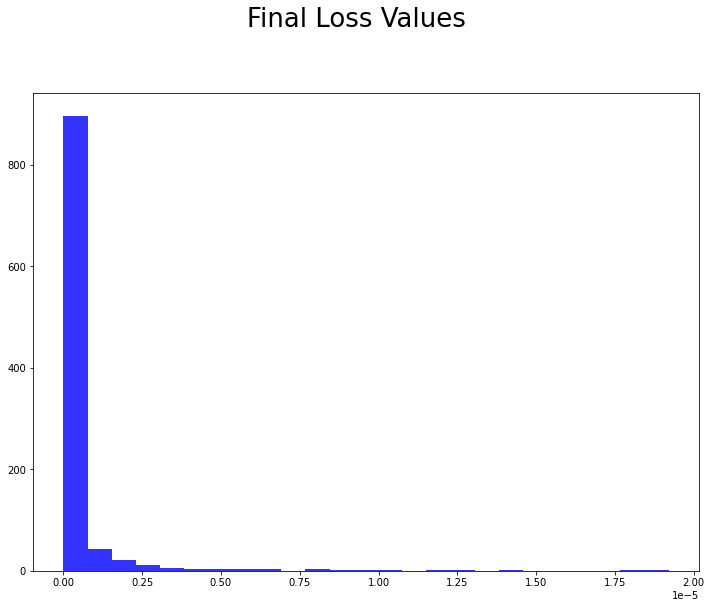

Minimum Loss: 6.357127152064945e-12
Mean Loss: 4.309465744905438e-07
Median Loss: 5.295128975558971e-08


In [22]:
# Default params
zak2d.params = {'step_size': 740., 'min_learning_rate': 0.23, 'max_learning_rate': 2.98}
zak2d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], break_opt=True)
points = zak2d.x_inits 

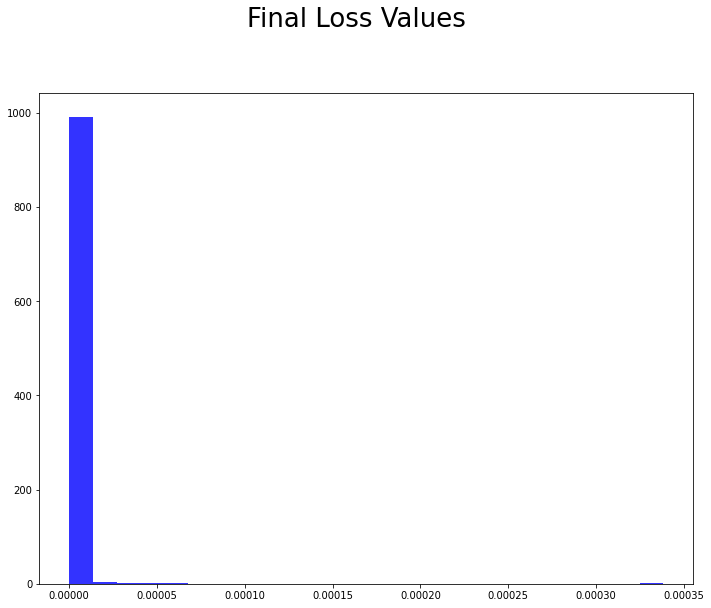

Minimum Loss: 2.6154591332816977e-12
Mean Loss: 8.161605252354195e-07
Median Loss: 3.877602439328024e-08


In [23]:
# Rosen params
zak2d.params = {'step_size': 1200.0, 'min_learning_rate': 0.51, 'max_learning_rate': 3.24}
zak2d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], points=points, break_opt=True)

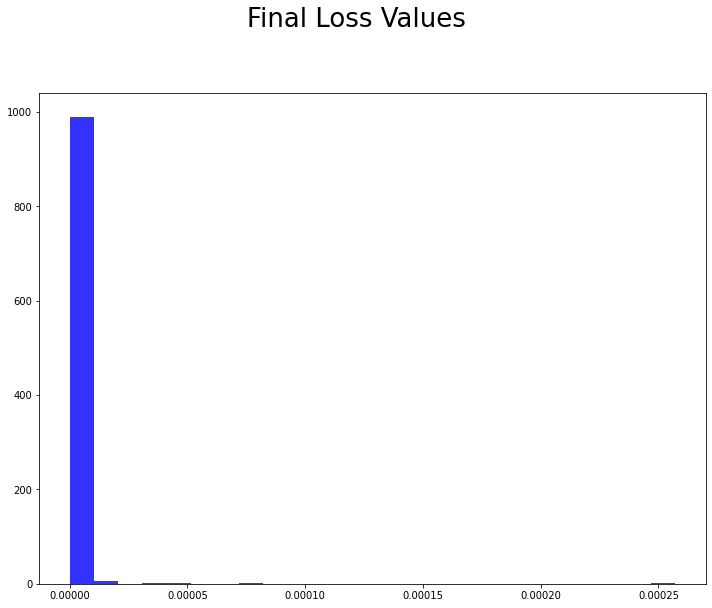

Minimum Loss: 1.544830150410896e-11
Mean Loss: 7.899893796148006e-07
Median Loss: 5.436922863545466e-08


In [24]:
# 2d params
zak2d.params = {'step_size': 1600, 'min_learning_rate': 0.248514389871424, 
                'max_learning_rate': 2.555801490675516}
zak2d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], points=points, break_opt=True)

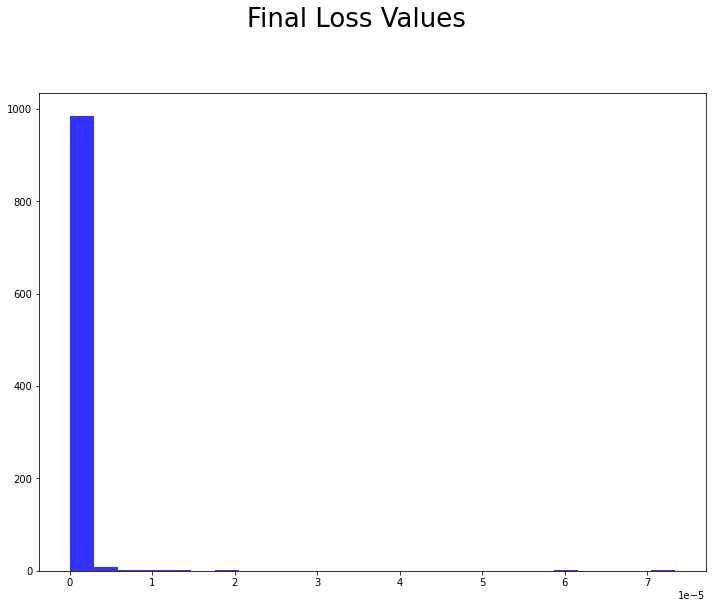

Minimum Loss: 3.7283049277152125e-12
Mean Loss: 3.465697376042098e-07
Median Loss: 3.050031107982341e-08


In [25]:
# 2d params
zak2d.params = {'step_size': 1400, 'min_learning_rate': 0.970283856049979, 
                'max_learning_rate': 3.252334647449645}
zak2d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], points=points, break_opt=True)

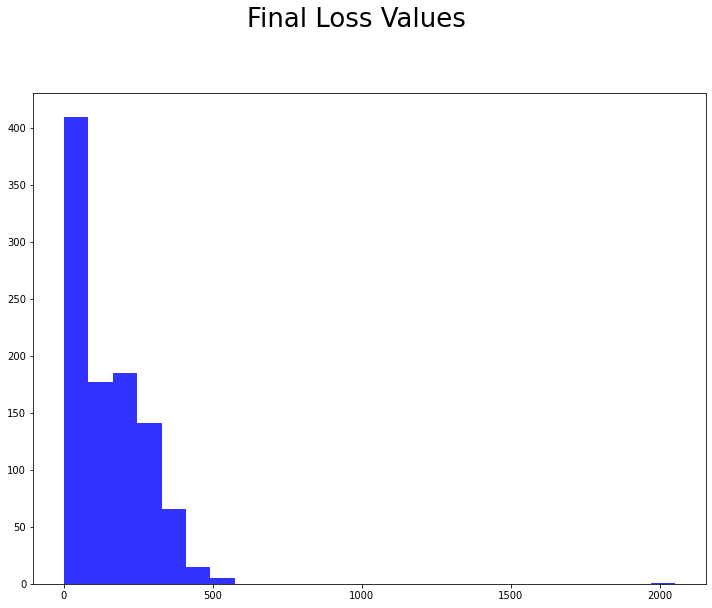

Minimum Loss: 2.331086486222691e-10
Mean Loss: 140.3371002895109
Median Loss: 127.53165379219104


In [30]:
# Default params
zak10d.params = {'step_size': 740., 'min_learning_rate': 0.23, 'max_learning_rate': 2.98}
zak10d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], break_opt=True)
points = zak10d.x_inits 

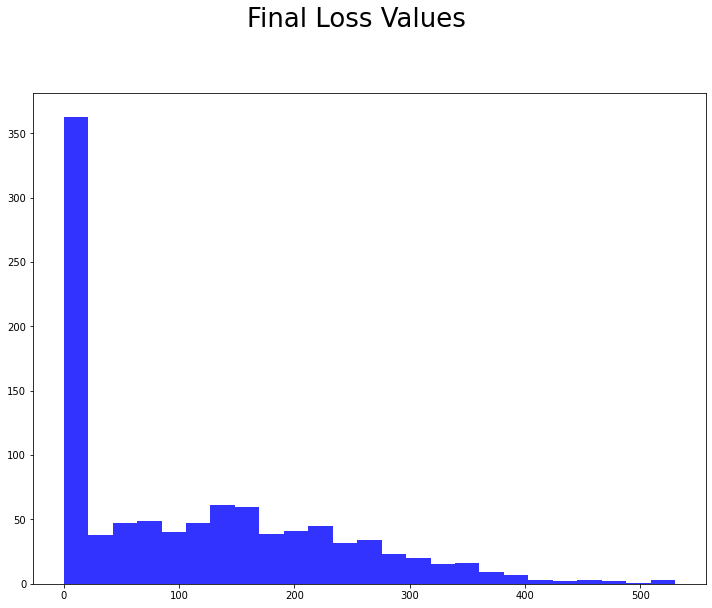

Minimum Loss: 8.307342132833005e-08
Mean Loss: 113.39975047359155
Median Loss: 86.20028737204518


In [31]:
# Rosen params
zak10d.params = {'step_size': 1200.0, 'min_learning_rate': 0.51, 'max_learning_rate': 3.24}
zak10d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], points=points, break_opt=True)

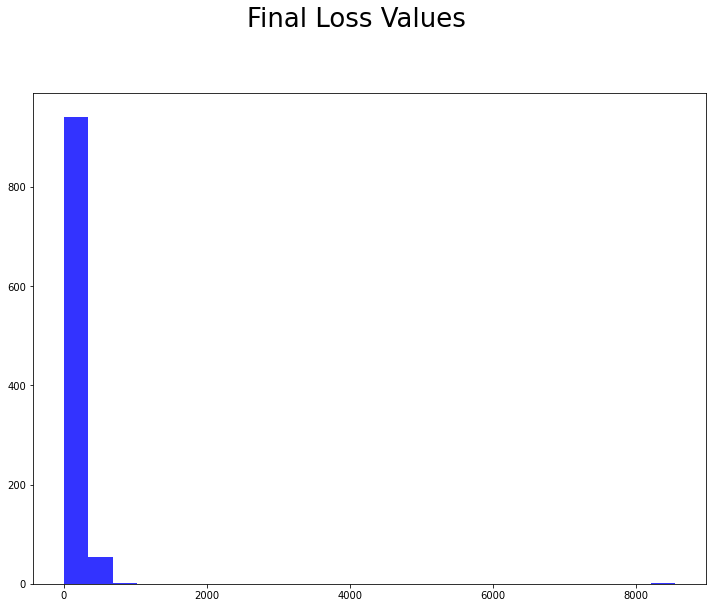

Minimum Loss: 1.0023985075333683e-09
Mean Loss: 139.25280242300562
Median Loss: 94.57980363530021


In [32]:
# 10d params
zak10d.params = {'step_size': 1600, 'min_learning_rate': 0.248514389871424, 
                'max_learning_rate': 2.555801490675516}
zak10d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], points=points, break_opt=True)

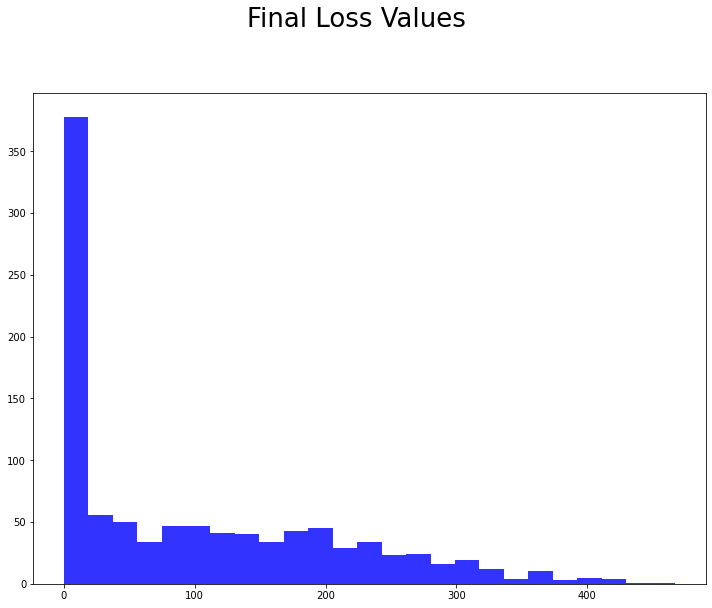

Minimum Loss: 1.106856825653062e-06
Mean Loss: 100.95473382134526
Median Loss: 64.08744343723396


In [33]:
# 10d params
zak10d.params = {'step_size': 1400, 'min_learning_rate': 0.970283856049979, 
                'max_learning_rate': 3.252334647449645}
zak10d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], points=points, break_opt=True)

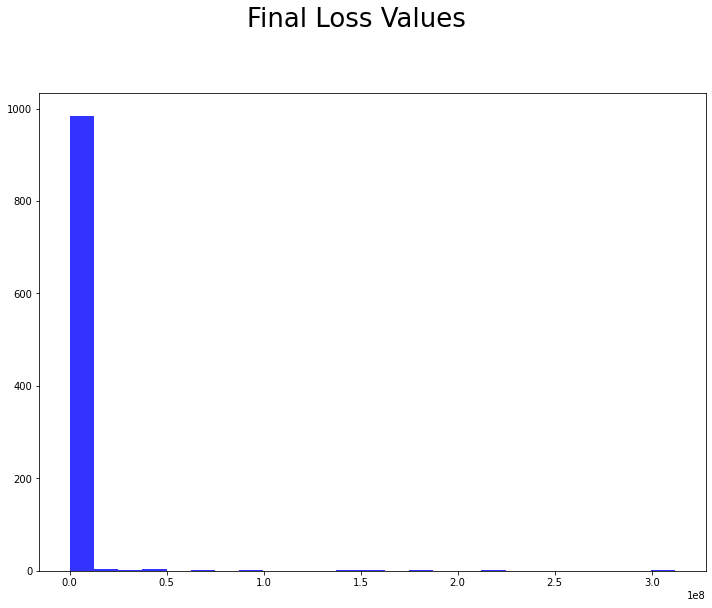

Minimum Loss: 2605.9294539350813
Mean Loss: 1546472.4453882992
Median Loss: 3632.1640685467123


In [34]:
# Default params
zak100d.params = {'step_size': 740., 'min_learning_rate': 0.23, 'max_learning_rate': 2.98}
zak100d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], break_opt=True)
points = zak100d.x_inits 

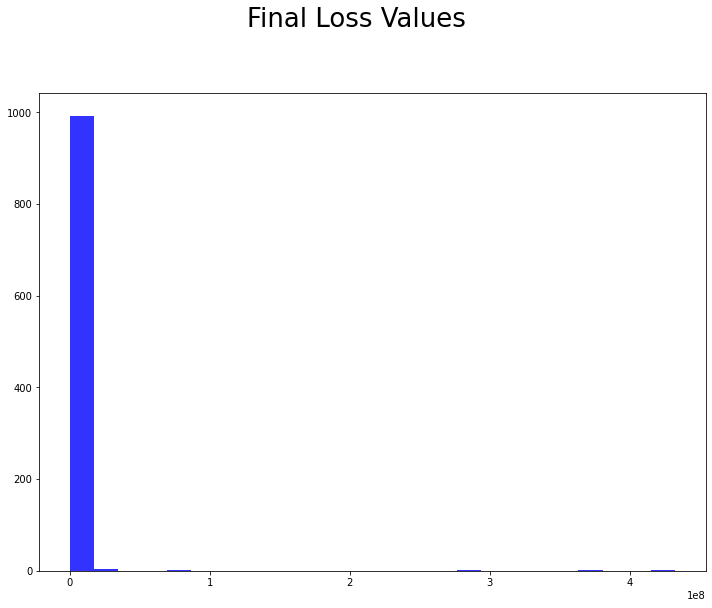

Minimum Loss: 2387.6095918873966
Mean Loss: 1416461.015013065
Median Loss: 3608.692893322591


In [35]:
# Rosen params
zak100d.params = {'step_size': 1200.0, 'min_learning_rate': 0.51, 'max_learning_rate': 3.24}
zak100d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], points=points, break_opt=True)

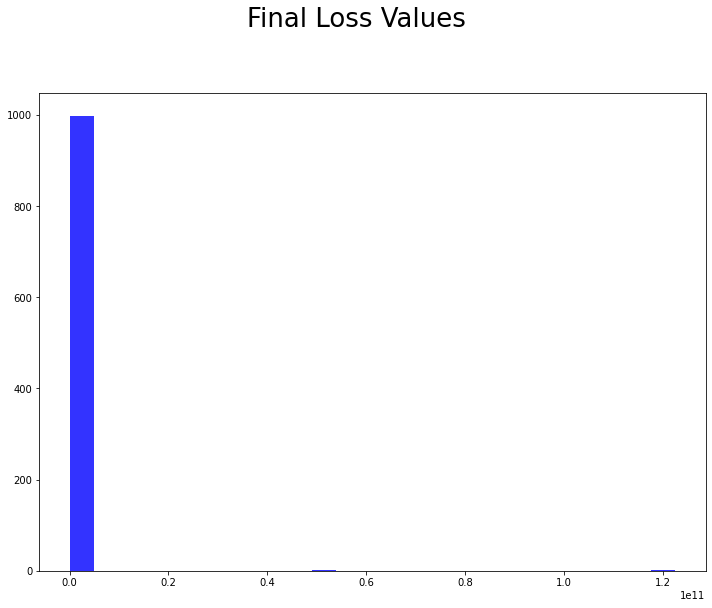

Minimum Loss: 2411.8696474292155
Mean Loss: 175846960.70629627
Median Loss: 3541.3896740836703


In [36]:
# 100d params
zak100d.params = {'step_size': 1600, 'min_learning_rate': 0.248514389871424, 
                'max_learning_rate': 2.555801490675516}
zak100d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], points=points, break_opt=True)

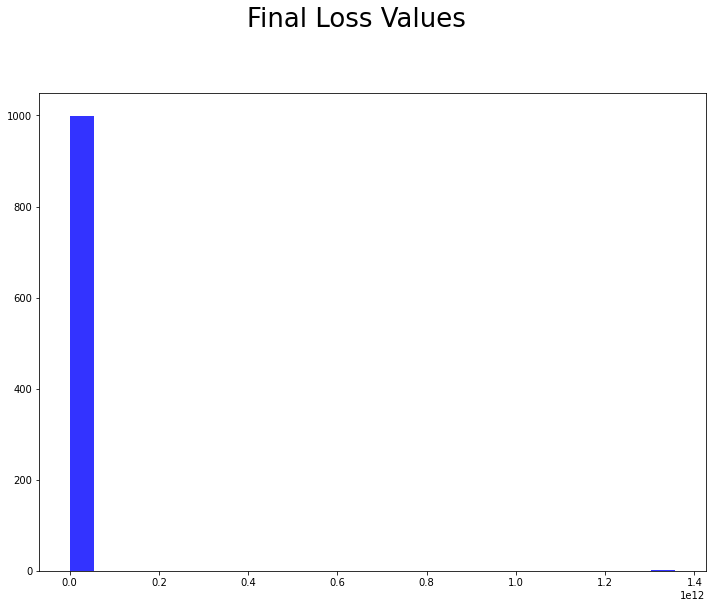

Minimum Loss: 2540.139503230989
Mean Loss: 1373325811.001168
Median Loss: 3770.20901327023


In [37]:
# 100d params
zak100d.params = {'step_size': 1400, 'min_learning_rate': 0.970283856049979, 
                'max_learning_rate': 3.252334647449645}
zak100d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], points=points, break_opt=True)

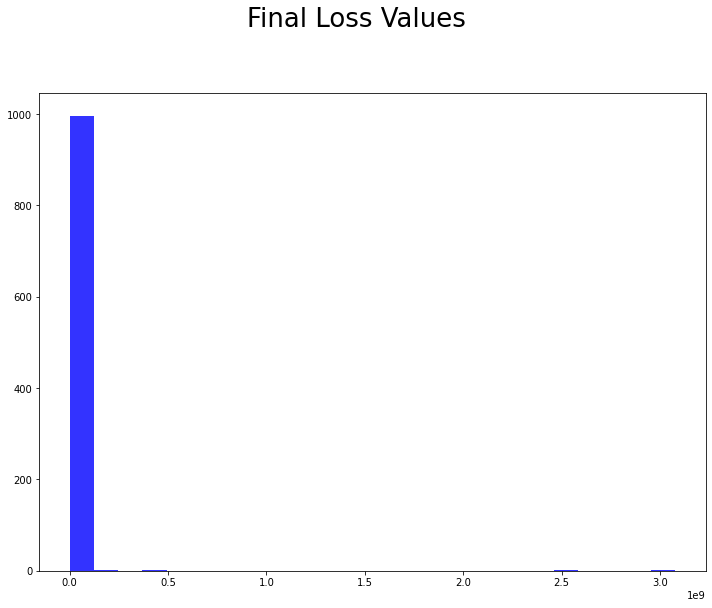

Minimum Loss: 2371.993398732661
Mean Loss: 6659967.79323785
Median Loss: 3564.95114812887


In [44]:
# 100d params
zak100d.params = {'step_size': 1600, 'min_learning_rate': 0.484906039553196, 
                'max_learning_rate': 3.105209098577002}
zak100d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], points=points, break_opt=True)

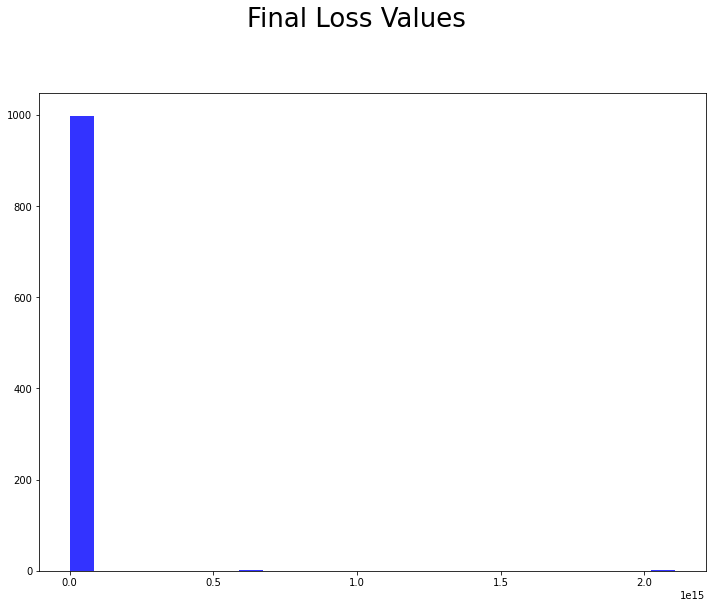

Minimum Loss: 31683.99198630197
Mean Loss: 2902186530354.474
Median Loss: 76286783.28982344


In [41]:
# Default params
zak1000d.params = {'step_size': 740., 'min_learning_rate': 0.23, 'max_learning_rate': 2.98}
zak1000d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], break_opt=True)
points = zak1000d.x_inits 

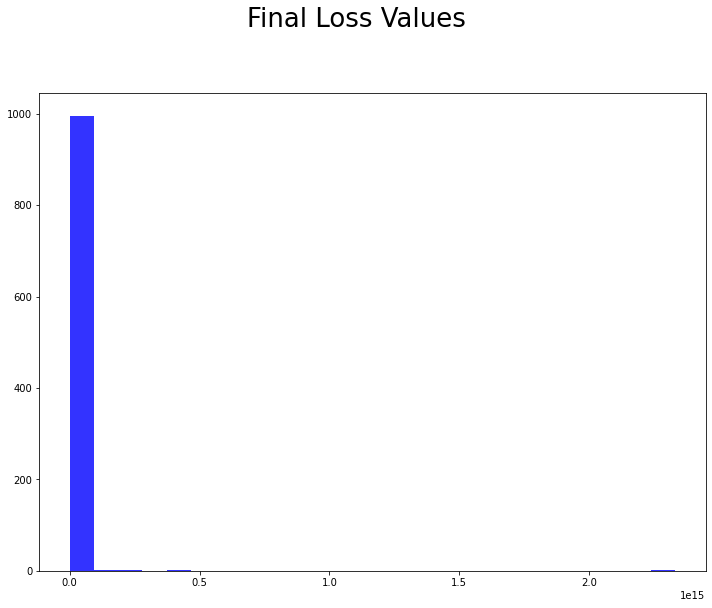

Minimum Loss: 34273.79943448543
Mean Loss: 4299574034291.323
Median Loss: 717335342.1419715


In [42]:
# Rosen params
zak1000d.params = {'step_size': 1200.0, 'min_learning_rate': 0.51, 'max_learning_rate': 3.24}
zak1000d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], points=points, break_opt=True)

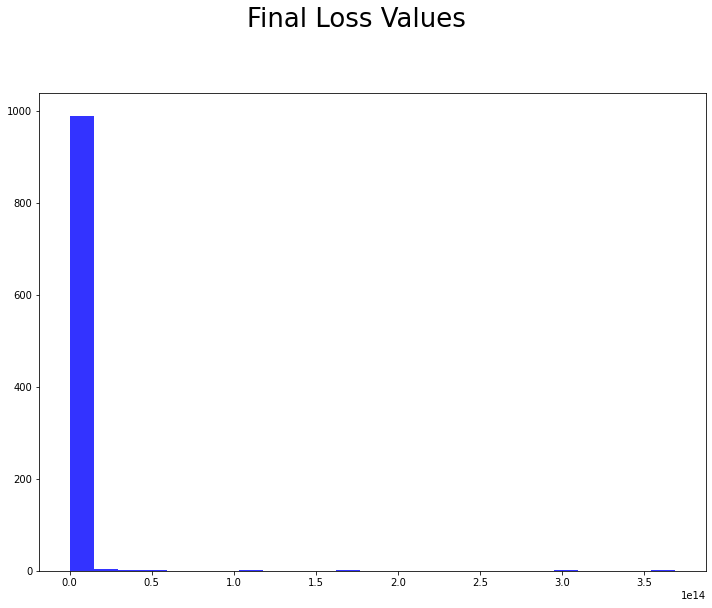

Minimum Loss: 30864.799614197032
Mean Loss: 1298152071804.2175
Median Loss: 57964415.51813807


In [43]:
# 1000d params
zak1000d.params = {'step_size': 1600, 'min_learning_rate': 0.248514389871424, 
                'max_learning_rate': 2.555801490675516}
zak1000d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], points=points, break_opt=True)

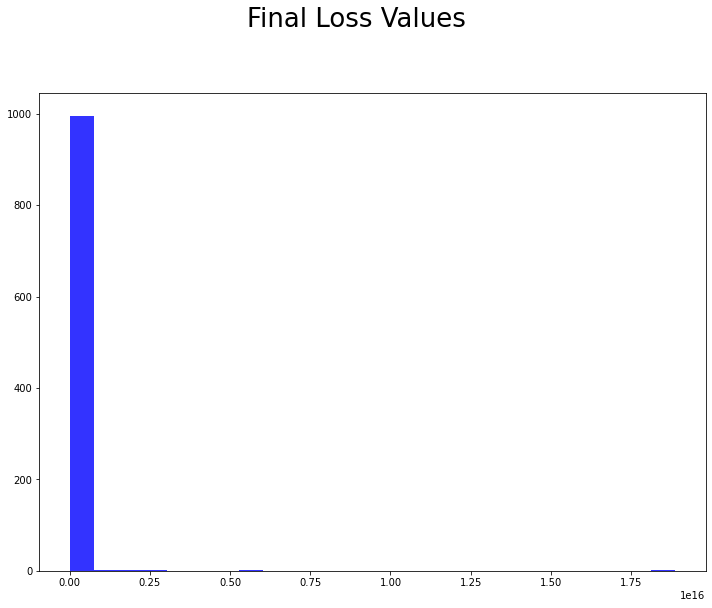

Minimum Loss: 215220.03636927885
Mean Loss: 35641433128138.23
Median Loss: 17635576252.927906


In [45]:
# 1000d params
zak1000d.params = {'step_size': 1400, 'min_learning_rate': 0.970283856049979, 
                'max_learning_rate': 3.252334647449645}
zak1000d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], points=points, break_opt=True)

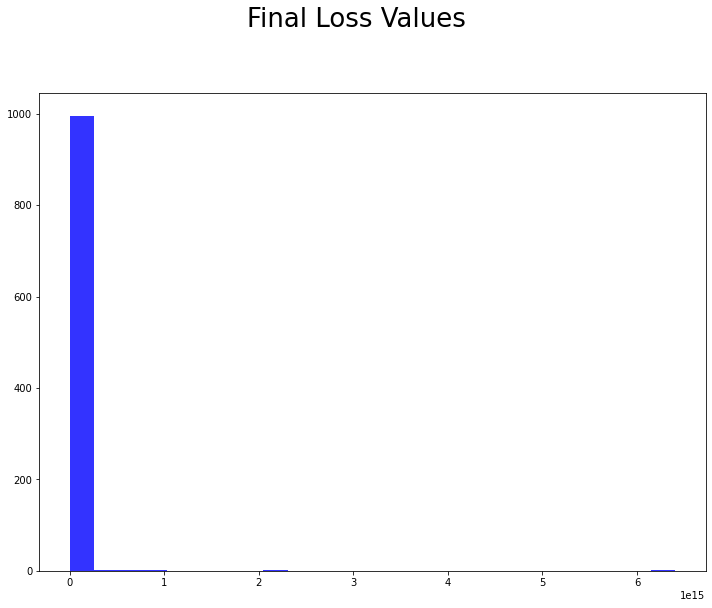

Minimum Loss: 45196.948761252715
Mean Loss: 11936893874420.846
Median Loss: 508079757.6306935


In [48]:
# 1000d params
zak1000d.params = {'step_size': 1400, 'min_learning_rate': 0.5, 
                'max_learning_rate': 3.32}
zak1000d.optimize(1000, 'random', False, [(False, 'finals', 'loss')], points=points, break_opt=True)

In [6]:
means2d = calc_means(zak2d, 1000, 0.5, num_delays=1000)
means10d = calc_means(zak10d, 1000, 0.5, num_delays=1000)
means100d = calc_means(zak100d, 1000, 0.5, num_delays=1000)
means1000d = calc_means(zak1000d, 1000, 0.5, num_delays=1000)

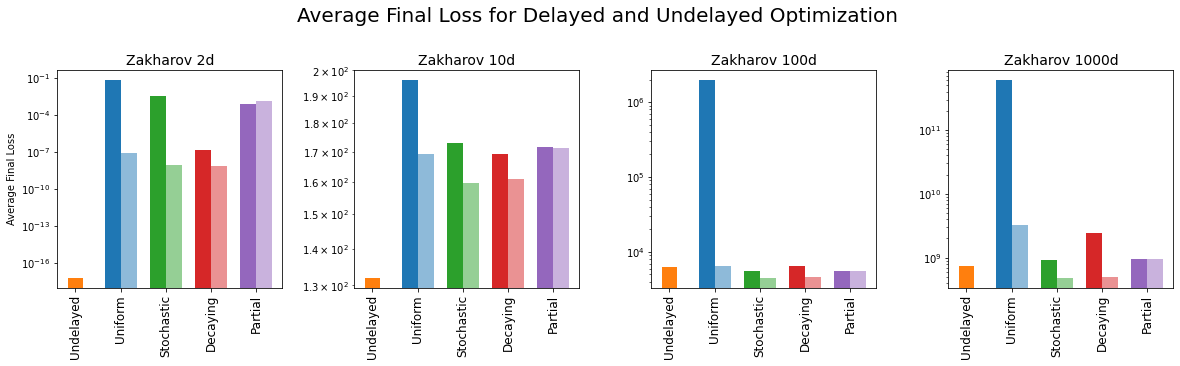

In [7]:
# Initialize figure
fig = plt.figure(figsize=(20, 4))
ax = fig.subplots(1, 4)

ax = plt.subplot(141)
plot_means(means2d)
plt.ylabel("Average Final Loss")
ax.set_yscale('log')
plt.title("Zakharov 2d", fontsize=14)

ax = plt.subplot(142)
plot_means(means10d)
ax.set_yscale('log')
plt.title("Zakharov 10d", fontsize=14)

ax = plt.subplot(143)
plot_means(means100d)
ax.set_yscale('log')
plt.title("Zakharov 100d", fontsize=14)

ax = plt.subplot(144)
plot_means(means1000d)
ax.set_yscale('log')
plt.title("Zakharov 1000d", fontsize=14)

fig.suptitle("Average Final Loss for Delayed and Undelayed Optimization", y=1.1, size=20)
plt.subplots_adjust(wspace=0.32)
plt.savefig("zak_types1.png", bbox_inches="tight")
plt.show()

In [8]:
means = np.array([means2d, means10d, means100d, means1000d])
np.save("zak_means.npy", means)

In [9]:
delay_name = ["Undelayed:", "Uniform full iters:", "Uniform delay:", "Stochastic full iters:", 
             "Stochastic delay:", "Decaying delay:", "Decaying Stochastic:", "Partial delay:",
             "Partial Stochastic:"]
means = {2:means2d, 10:means10d, 100:means100d, 1000:means1000d}

for n in [2, 10, 100, 1000]:
    print(f"Zakharov {n}d")
    for i in range(9):
        print(delay_name[i], means[n][i])
    print('\n')

Zakharov 2d
Undelayed: 5.33300475534487e-10
Uniform full iters: 0.006192370010464652
Uniform delay: 1.412940780152869e-07
Stochastic full iters: 1.811410078508155e-06
Stochastic delay: 4.1982311062270714e-08
Decaying delay: 1.2207596215163923e-07
Decaying Stochastic: 2.2518285284269535e-07
Partial delay: 8.98016056029856e-07
Partial Stochastic: 2.494019449756623e-07


Zakharov 10d
Undelayed: 134.58883154963934
Uniform full iters: 179.41375179085205
Uniform delay: 163.6916941507638
Stochastic full iters: 170.16905029386672
Stochastic delay: 160.1852318999194
Decaying delay: 163.86536056111805
Decaying Stochastic: 162.16771785177627
Partial delay: 167.55396754488038
Partial Stochastic: 172.4411506751799


Zakharov 100d
Undelayed: 5719.992839786975
Uniform full iters: 1628313.2583354202
Uniform delay: 16571.10112507627
Stochastic full iters: 8974.641655486885
Stochastic delay: 7082.094902381715
Decaying delay: 16607.952789117513
Decaying Stochastic: 7106.702342615951
Partial delay: 8990.2

In [7]:
# Initialize for max_L = 2
max_L = 2
zak2d = Analyzer(2, loss_name, max_L=max_L, verbose=False)
zak10d = Analyzer(10, loss_name, max_L=max_L, verbose=False)
zak100d = Analyzer(100, loss_name, max_L=max_L, verbose=False)
zak1000d = Analyzer(1000, loss_name, max_L=max_L, verbose=False)

In [8]:
means2d = calc_means(zak2d, 1000, 0.5, num_delays=1000)
means10d = calc_means(zak10d, 1000, 0.5, num_delays=1000)
means100d = calc_means(zak100d, 1000, 0.5, num_delays=1000)
means1000d = calc_means(zak1000d, 1000, 0.5, num_delays=1000)

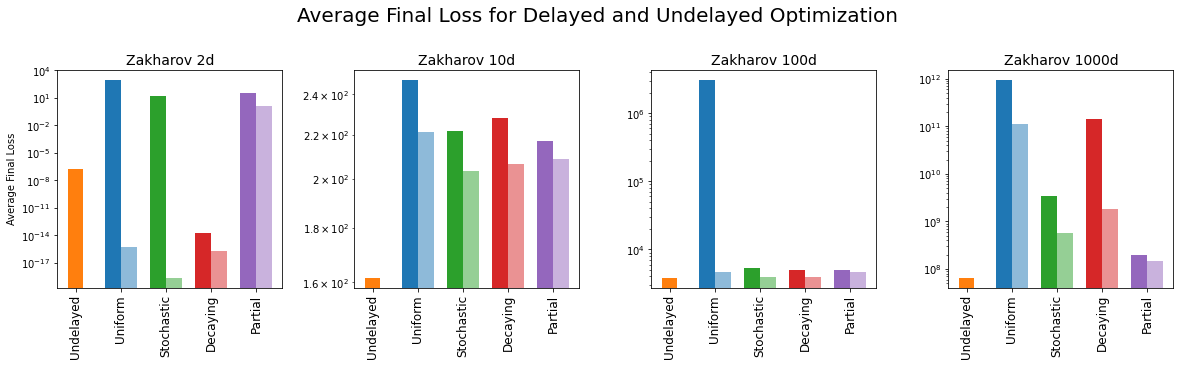

In [9]:
# Initialize figure
fig = plt.figure(figsize=(20, 4))
ax = fig.subplots(1, 4)

ax = plt.subplot(141)
plot_means(means2d)
plt.ylabel("Average Final Loss")
ax.set_yscale('log')
plt.title("Zakharov 2d", fontsize=14)

ax = plt.subplot(142)
plot_means(means10d)
ax.set_yscale('log')
plt.title("Zakharov 10d", fontsize=14)

ax = plt.subplot(143)
plot_means(means100d)
ax.set_yscale('log')
plt.title("Zakharov 100d", fontsize=14)

ax = plt.subplot(144)
plot_means(means1000d)
ax.set_yscale('log')
plt.title("Zakharov 1000d", fontsize=14)

fig.suptitle("Average Final Loss for Delayed and Undelayed Optimization", y=1.1, size=20)
plt.subplots_adjust(wspace=0.32)
plt.savefig("zak_types2.png", bbox_inches="tight")
plt.show()

In [10]:
means = np.array([means2d, means10d, means100d, means1000d])
np.save("zak_means2.npy", means)

In [11]:
delay_name = ["Undelayed:", "Uniform full iters:", "Uniform delay:", "Stochastic full iters:", 
             "Stochastic delay:", "Decaying delay:", "Decaying Stochastic:", "Partial delay:",
             "Partial Stochastic:"]
means = {2:means2d, 10:means10d, 100:means100d, 1000:means1000d}

for n in [2, 10, 100, 1000]:
    print(f"Zakharov {n}d")
    for i in range(9):
        print(delay_name[i], means[n][i])
    print('\n')

Zakharov 2d
Undelayed: 1.8064285811382606e-07
Uniform full iters: 871.0876589647968
Uniform delay: 5.494742312714152e-16
Stochastic full iters: 16.831250623396436
Stochastic delay: 2.544503420800948e-19
Decaying delay: 1.8288870171612814e-14
Decaying Stochastic: 1.9393145121125274e-16
Partial delay: 36.42198056013876
Partial Stochastic: 1.4150848559003022


Zakharov 10d
Undelayed: 161.67033349768587
Uniform full iters: 247.5662290500541
Uniform delay: 221.31270294254273
Stochastic full iters: 221.8063907690157
Stochastic delay: 203.248917538304
Decaying delay: 228.18886503113592
Decaying Stochastic: 206.68712676269791
Partial delay: 217.12865357665166
Partial Stochastic: 208.97306664122178


Zakharov 100d
Undelayed: 3844.4455025785596
Uniform full iters: 3085499.2445087726
Uniform delay: 4729.349088089237
Stochastic full iters: 5253.519125049144
Stochastic delay: 3866.6374350841584
Decaying delay: 4958.450144072182
Decaying Stochastic: 3972.5306507022487
Partial delay: 4955.38531756482

In [12]:
# Initialize for max_L = 3
max_L = 3
zak2d = Analyzer(2, loss_name, max_L=max_L, verbose=False)
zak10d = Analyzer(10, loss_name, max_L=max_L, verbose=False)
zak100d = Analyzer(100, loss_name, max_L=max_L, verbose=False)
zak1000d = Analyzer(1000, loss_name, max_L=max_L, verbose=False)

In [13]:
means2d = calc_means(zak2d, 1000, 0.5, num_delays=1000)
means10d = calc_means(zak10d, 1000, 0.5, num_delays=1000)
means100d = calc_means(zak100d, 1000, 0.5, num_delays=1000)
means1000d = calc_means(zak1000d, 1000, 0.5, num_delays=1000)

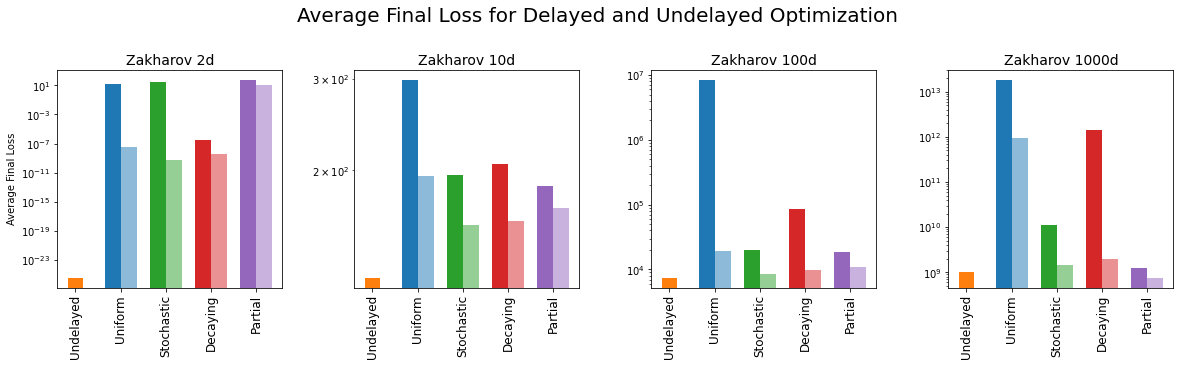

In [14]:
# Initialize figure
fig = plt.figure(figsize=(20, 4))
ax = fig.subplots(1, 4)

ax = plt.subplot(141)
plot_means(means2d)
plt.ylabel("Average Final Loss")
ax.set_yscale('log')
plt.title("Zakharov 2d", fontsize=14)

ax = plt.subplot(142)
plot_means(means10d)
ax.set_yscale('log')
plt.title("Zakharov 10d", fontsize=14)

ax = plt.subplot(143)
plot_means(means100d)
ax.set_yscale('log')
plt.title("Zakharov 100d", fontsize=14)

ax = plt.subplot(144)
plot_means(means1000d)
ax.set_yscale('log')
plt.title("Zakharov 1000d", fontsize=14)

fig.suptitle("Average Final Loss for Delayed and Undelayed Optimization", y=1.1, size=20)
plt.subplots_adjust(wspace=0.32)
plt.savefig("zak_types3.png", bbox_inches="tight")
plt.show()

In [15]:
means = np.array([means2d, means10d, means100d, means1000d])
np.save("zak_means3.npy", means)

In [16]:
delay_name = ["Undelayed:", "Uniform full iters:", "Uniform delay:", "Stochastic full iters:", 
             "Stochastic delay:", "Decaying delay:", "Decaying Stochastic:", "Partial delay:",
             "Partial Stochastic:"]
means = {2:means2d, 10:means10d, 100:means100d, 1000:means1000d}

for n in [2, 10, 100, 1000]:
    print(f"Zakharov {n}d")
    for i in range(9):
        print(delay_name[i], means[n][i])
    print('\n')

Zakharov 2d
Undelayed: 3.45379313690971e-26
Uniform full iters: 16.162359883651344
Uniform delay: 3.493042399981643e-08
Stochastic full iters: 31.588596539036267
Stochastic delay: 4.844898623802458e-10
Decaying delay: 2.6664641259388215e-07
Decaying Stochastic: 3.7060325101618797e-09
Partial delay: 54.99848519178414
Partial Stochastic: 11.7511954292066


Zakharov 10d
Undelayed: 124.36800655350126
Uniform full iters: 298.3509728503097
Uniform delay: 195.11482069545286
Stochastic full iters: 195.57481969316018
Stochastic delay: 156.81577723915422
Decaying delay: 205.7619315010173
Decaying Stochastic: 160.08865112185728
Partial delay: 186.29072754192015
Partial Stochastic: 169.47865268690066


Zakharov 100d
Undelayed: 7476.938384013677
Uniform full iters: 8393761.997730011
Uniform delay: 19034.995213957885
Stochastic full iters: 20140.124112155052
Stochastic delay: 8397.554944304336
Decaying delay: 86800.91560614352
Decaying Stochastic: 9899.64252576468
Partial delay: 18318.053181559935
P

In [17]:
# Initialize for max_L = 4
max_L = 4
zak2d = Analyzer(2, loss_name, max_L=max_L, verbose=False)
zak10d = Analyzer(10, loss_name, max_L=max_L, verbose=False)
zak100d = Analyzer(100, loss_name, max_L=max_L, verbose=False)
zak1000d = Analyzer(1000, loss_name, max_L=max_L, verbose=False)

In [18]:
means2d = calc_means(zak2d, 1000, 0.5, num_delays=1000)
means10d = calc_means(zak10d, 1000, 0.5, num_delays=1000)
means100d = calc_means(zak100d, 1000, 0.5, num_delays=1000)
means1000d = calc_means(zak1000d, 1000, 0.5, num_delays=1000)

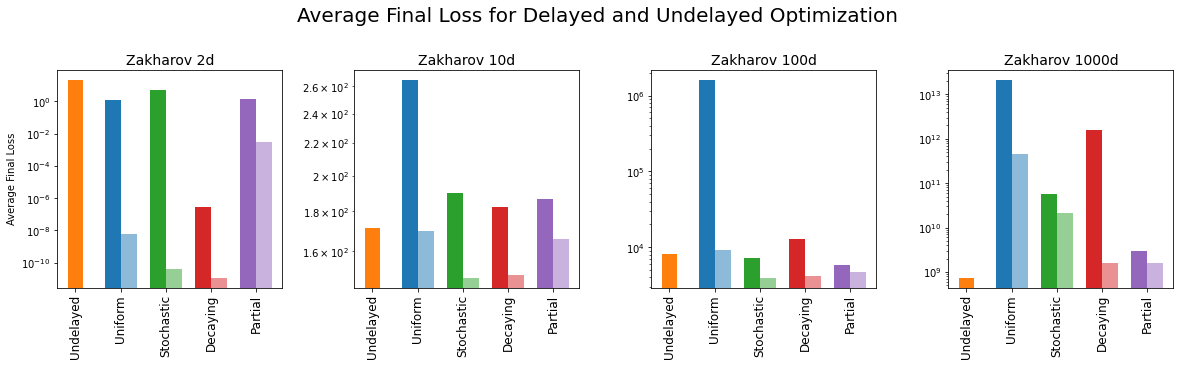

In [19]:
# Initialize figure
fig = plt.figure(figsize=(20, 4))
ax = fig.subplots(1, 4)

ax = plt.subplot(141)
plot_means(means2d)
plt.ylabel("Average Final Loss")
ax.set_yscale('log')
plt.title("Zakharov 2d", fontsize=14)

ax = plt.subplot(142)
plot_means(means10d)
ax.set_yscale('log')
plt.title("Zakharov 10d", fontsize=14)

ax = plt.subplot(143)
plot_means(means100d)
ax.set_yscale('log')
plt.title("Zakharov 100d", fontsize=14)

ax = plt.subplot(144)
plot_means(means1000d)
ax.set_yscale('log')
plt.title("Zakharov 1000d", fontsize=14)

fig.suptitle("Average Final Loss for Delayed and Undelayed Optimization", y=1.1, size=20)
plt.subplots_adjust(wspace=0.32)
plt.savefig("zak_types4.png", bbox_inches="tight")
plt.show()

In [20]:
means = np.array([means2d, means10d, means100d, means1000d])
np.save("zak_means4.npy", means)

In [21]:
delay_name = ["Undelayed:", "Uniform full iters:", "Uniform delay:", "Stochastic full iters:", 
             "Stochastic delay:", "Decaying delay:", "Decaying Stochastic:", "Partial delay:",
             "Partial Stochastic:"]
means = {2:means2d, 10:means10d, 100:means100d, 1000:means1000d}

for n in [2, 10, 100, 1000]:
    print(f"Zakharov {n}d")
    for i in range(9):
        print(delay_name[i], means[n][i])
    print('\n')

Zakharov 2d
Undelayed: 20.853075540574235
Uniform full iters: 1.163275128817385
Uniform delay: 6.004307390580687e-09
Stochastic full iters: 5.012128397169727
Stochastic delay: 4.0395090443304166e-11
Decaying delay: 2.850993771530986e-07
Decaying Stochastic: 1.1904338886465085e-11
Partial delay: 1.3212995667087741
Partial Stochastic: 0.0031002526281550973


Zakharov 10d
Undelayed: 171.31268258856224
Uniform full iters: 264.8933816063975
Uniform delay: 169.75328834055964
Stochastic full iters: 189.900245288119
Stochastic delay: 148.08345212534257
Decaying delay: 182.33871357645893
Decaying Stochastic: 149.16721981505515
Partial delay: 186.88273375741286
Partial Stochastic: 165.9917619235591


Zakharov 100d
Undelayed: 8150.967634190147
Uniform full iters: 1603541.6907938158
Uniform delay: 9284.444467852236
Stochastic full iters: 7317.803912176333
Stochastic delay: 3975.3373882020883
Decaying delay: 12692.438520653192
Decaying Stochastic: 4216.4892431865965
Partial delay: 5860.843881428846

In [22]:
# Initialize for max_L = 5
max_L = 5
zak2d = Analyzer(2, loss_name, max_L=max_L, verbose=False)
zak10d = Analyzer(10, loss_name, max_L=max_L, verbose=False)
zak100d = Analyzer(100, loss_name, max_L=max_L, verbose=False)
zak1000d = Analyzer(1000, loss_name, max_L=max_L, verbose=False)

In [23]:
means2d = calc_means(zak2d, 1000, 0.5, num_delays=1000)
means10d = calc_means(zak10d, 1000, 0.5, num_delays=1000)
means100d = calc_means(zak100d, 1000, 0.5, num_delays=1000)
means1000d = calc_means(zak1000d, 1000, 0.5, num_delays=1000)

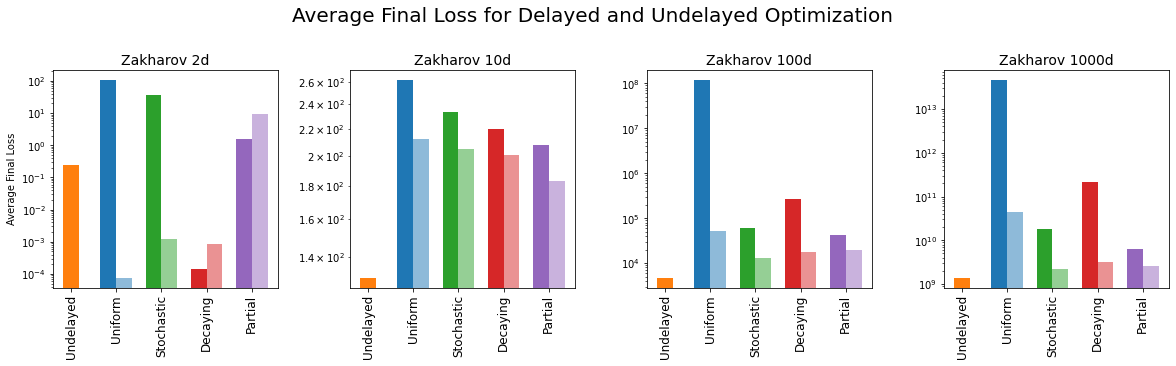

In [24]:
# Initialize figure
fig = plt.figure(figsize=(20, 4))
ax = fig.subplots(1, 4)

ax = plt.subplot(141)
plot_means(means2d)
plt.ylabel("Average Final Loss")
ax.set_yscale('log')
plt.title("Zakharov 2d", fontsize=14)

ax = plt.subplot(142)
plot_means(means10d)
ax.set_yscale('log')
plt.title("Zakharov 10d", fontsize=14)

ax = plt.subplot(143)
plot_means(means100d)
ax.set_yscale('log')
plt.title("Zakharov 100d", fontsize=14)

ax = plt.subplot(144)
plot_means(means1000d)
ax.set_yscale('log')
plt.title("Zakharov 1000d", fontsize=14)

fig.suptitle("Average Final Loss for Delayed and Undelayed Optimization", y=1.1, size=20)
plt.subplots_adjust(wspace=0.32)
plt.savefig("zak_types5.png", bbox_inches="tight")
plt.show()

In [25]:
means = np.array([means2d, means10d, means100d, means1000d])
np.save("zak_means5.npy", means)

In [26]:
delay_name = ["Undelayed:", "Uniform full iters:", "Uniform delay:", "Stochastic full iters:", 
             "Stochastic delay:", "Decaying delay:", "Decaying Stochastic:", "Partial delay:",
             "Partial Stochastic:"]
means = {2:means2d, 10:means10d, 100:means100d, 1000:means1000d}

for n in [2, 10, 100, 1000]:
    print(f"Zakharov {n}d")
    for i in range(9):
        print(delay_name[i], means[n][i])
    print('\n')

Zakharov 2d
Undelayed: 0.24594238781638064
Uniform full iters: 106.50739341885443
Uniform delay: 7.62848484016458e-05
Stochastic full iters: 36.07131320147928
Stochastic delay: 0.0012578830567626365
Decaying delay: 0.00013690368294508797
Decaying Stochastic: 0.0008576689691851857
Partial delay: 1.5434878316968672
Partial Stochastic: 9.080016841621982


Zakharov 10d
Undelayed: 129.9656090788425
Uniform full iters: 261.3937664004086
Uniform delay: 211.84552613922233
Stochastic full iters: 233.0229637557862
Stochastic delay: 204.89350483453438
Decaying delay: 220.13122974998865
Decaying Stochastic: 200.41767247164967
Partial delay: 207.82058513501437
Partial Stochastic: 182.99725632781494


Zakharov 100d
Undelayed: 4739.192929988465
Uniform full iters: 118617019.07698685
Uniform delay: 52844.73358122403
Stochastic full iters: 59321.16385554613
Stochastic delay: 13147.163928948115
Decaying delay: 266863.6763235663
Decaying Stochastic: 17666.74868343641
Partial delay: 42628.95263483745
Part